In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data Generation
===

In [3]:
np.random.seed(10)
p, q = (np.random.rand(i, 2) for i in (4, 5))
p_big, q_big = (np.random.rand(i, 80) for i in (100, 120))

print(p, "\n\n", q)

[[0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]] 

 [[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]]


Solution
===

In [4]:
def quick(p, q):
    D = np.sqrt(np.sum((p.reshape(p.shape[0], 1, p.shape[1])-q.reshape(1, q.shape[0], q.shape[1]))**2, axis=2))
    return D

In [5]:
def even_more_naive(p, q):
    D = np.array([], dtype=np.float64).reshape(0, q.shape[0])
    for rowp in p:
        d_v = np.array([], dtype=np.float64).reshape(1, 0)
        for rowq in q:
            d = np.sqrt(np.sum((rowp - rowq)**2))
            d = np.array(d).reshape(1, 1)
            d_v = np.hstack([d_v, d])
        D = np.vstack([D, d_v])
    return D


In [6]:
def naive(p, q):
    D = np.array([], dtype=np.int64).reshape(0, q.shape[0])
    for row in p:
        d = np.sqrt(np.sum((q - row)**2, axis=1))
        D = np.vstack([D, d])
    return D


### Use matching indices

Instead of iterating through indices, one can use them directly to parallelize the operations with Numpy.

In [7]:
rows, cols = np.indices((p.shape[0], q.shape[0]))
print(rows, end='\n\n')
print(cols)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


In [8]:
print(p[rows.ravel()], end='\n\n')
print(q[cols.ravel()])

[[0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]]

[[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607

In [9]:
def with_indices(p, q):
    rows, cols = np.indices((p.shape[0], q.shape[0]))
    D = np.sqrt(np.sum((p[rows.ravel()]-q[cols.ravel()])**2, axis=1))
    D = D.reshape(p.shape[0], q.shape[0])
    return D

### Use a library

`scipy` is the equivalent of matlab toolboxes and have a lot to offer. Actually the pairwise computation is part of the library through the `spatial` module.

In [10]:
from scipy.spatial.distance import cdist

def scipy_version(p, q):
    return cdist(p, q)

### Numpy Magic

In [11]:
def tensor_broadcasting(p, q):
    return np.sqrt(np.sum((p[:, np.newaxis, :]-q[np.newaxis, :, :])**2, axis=2))


# Compare methods

In [12]:
methods = [with_indices, naive, quick, tensor_broadcasting, scipy_version]
timers = []
for f in methods:
    r = %timeit -o f(p_big, q_big)
    timers.append(r)

15.5 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.76 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.12 ms ± 62.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.85 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.02 ms ± 48.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


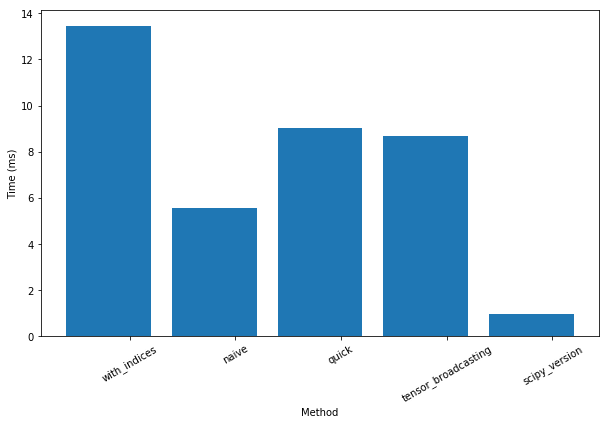

In [13]:
plt.figure(figsize=(10,6))
plt.bar(np.arange(len(methods)), [r.best*1000 for r in timers], log=False)  # Set log to True for logarithmic scale
plt.xticks(np.arange(len(methods))+0.2, [f.__name__ for f in methods], rotation=30)
plt.xlabel('Method')
plt.ylabel('Time (ms)')
plt.show()